# Setup

In [1]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape,LSTM, SimpleRNN, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python

In [2]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Symmetric (secret-key) encryption

## Model `crypto1` (Google)

This model was build according to the specifications from Google's paper *Learning to protect communications with adversarial neural cryptography*.

In [3]:
model_name = 'crypto1'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

# RNN

### Network arch

In [4]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

x = SimpleRNN(16,return_sequences=True)(areshape)
x = SimpleRNN(64,return_sequences=True)(x)
x = SimpleRNN(128)(x)
x = Dense(4096,activation='relu')(x)
x = Dropout(0.5)(x)
aoutput = Dense(16,activation='relu')(x)
alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)


x = SimpleRNN(16,return_sequences=True)(breshape)
x = SimpleRNN(64,return_sequences=True)(x)
x = SimpleRNN(128)(x)
x = Dense(4096,activation='relu')(x)
x = Dropout(0.5)(x)
boutput = Dense(16,activation='relu')(x)

bob = Model([binput0, binput1], boutput, name='bob')
bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)


x = SimpleRNN(16,return_sequences=True)(ereshape)
x = SimpleRNN(64,return_sequences=True)(x)
x = SimpleRNN(128)(x)
x = Dense(32,activation='relu')(x)
x = Dropout(0.5)(x)
eoutput = Dense(16,activation='relu')(x)
eve = Model(einput, eoutput, name='eve')
eve.summary()


Model: "alice"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        concatenate_1[0][0]          

In [5]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [6]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [7]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


### Train / save / restore

In [8]:
abelosses = []
boblosses = []
evelosses = []

In [9]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512

Epoch   0:  99% | abe: 8.059 | eve: 7.915 | bob: 8.049
Epoch   1:  99% | abe: 7.144 | eve: 7.178 | bob: 7.055
Epoch   2:  99% | abe: 5.215 | eve: 6.249 | bob: 5.029
Epoch   3:  99% | abe: 4.124 | eve: 5.609 | bob: 3.865
Epoch   4:  99% | abe: 3.225 | eve: 5.101 | bob: 2.928
Epoch   5:  99% | abe: 2.473 | eve: 4.612 | bob: 2.142
Epoch   6:  99% | abe: 2.192 | eve: 4.066 | bob: 1.853
Epoch   7:  99% | abe: 2.135 | eve: 3.590 | bob: 1.755
Epoch   8:  99% | abe: 2.104 | eve: 3.260 | bob: 1.692
Epoch   9:  99% | abe: 2.075 | eve: 3.082 | bob: 1.643
Epoch  10:  99% | abe: 2.050 | eve: 2.973 | bob: 1.598
Epoch  11:  99% | abe: 1.770 | eve: 2.988 | bob: 1.270
Epoch  12:  99% | abe: 1.627 | eve: 2.890 | bob: 1.135
Epoch  13:  99% | abe: 1.604 | eve: 2.786 | bob: 1.102
Epoch  14:  99% | abe: 1.580 | eve: 2.703 | bob: 1.069
Epoch  15:  99% | abe: 1.568 | eve: 2.648 | bob: 1.053
Epoch  16:  99% | abe: 1.556 | eve: 2.597 | bob: 1.028
Epoch  17:  

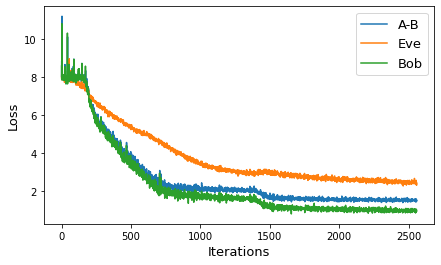

In [10]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [11]:
if False: #Don't overwrite by accident
    alice.save(alice_file + '.h5', overwrite=True)
    bob.save(bob_file + '.h5', overwrite=True)
    eve.save(eve_file + '.h5', overwrite=True)

In [12]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

OSError: Unable to open file (unable to open file: name = 'models/crypto/crypto1-alice.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Evaluate

In [47]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  88.88 %
Eve % correct:  0.21 %


### Freeze Alice-Bob

In [48]:
if False:
    alice = load_model(alice_file + '.h5')
    bob = load_model(bob_file + '.h5')
    eve = load_model(eve_file + '.h5')

aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = Adam()#RMSprop(lr=0.001) #default 0.001

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

abelosses = []
boblosses = []
evelosses = []

/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


In [49]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        # Train Eve model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - eveloss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 0.273 | eve: 4.850 | bob: 0.118
Epoch   1:  99% | abe: 0.274 | eve: 4.843 | bob: 0.118
Epoch   2:  99% | abe: 0.274 | eve: 4.845 | bob: 0.118
Epoch   3:  99% | abe: 0.274 | eve: 4.848 | bob: 0.119
Epoch   4:  99% | abe: 0.272 | eve: 4.855 | bob: 0.118
Epoch   5:  99% | abe: 0.272 | eve: 4.837 | bob: 0.116
Epoch   6:  99% | abe: 0.274 | eve: 4.843 | bob: 0.119
Epoch   7:  99% | abe: 0.272 | eve: 4.848 | bob: 0.117
Epoch   8:  99% | abe: 0.272 | eve: 4.849 | bob: 0.116
Epoch   9:  99% | abe: 0.273 | eve: 4.852 | bob: 0.118
Epoch  10:  99% | abe: 0.275 | eve: 4.840 | bob: 0.119
Epoch  11:  99% | abe: 0.273 | eve: 4.852 | bob: 0.118
Epoch  12:  99% | abe: 0.272 | eve: 4.845 | bob: 0.116
Epoch  13:  99% | abe: 0.275 | eve: 4.831 | bob: 0.118
Epoch  14:  99% | abe: 0.274 | eve: 4.843 | bob: 0.118
Epoch  15:  99% | abe: 0.277 | eve: 4.823 | bob: 0.119
Epoch  16:  99% | abe: 0.272 | eve: 4.866 | bob: 0.118
Epoch  17:  9

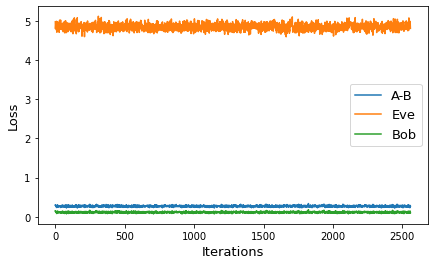

In [50]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [51]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  88.52 %
Eve % correct:  0.21 %


## CNN

In [38]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)

aconv4a = Activation('sigmoid')(aconv4)



aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')
bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')
eve.summary()

Model: "alice"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        concatenate_1[0][0]          

In [70]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [71]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


In [72]:
abelosses = []
boblosses = []
evelosses = []

### Encoding distribution

In [53]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

NameError: name 'encoder' is not defined

Let's plot a few of the encoded vectors' coodinates:

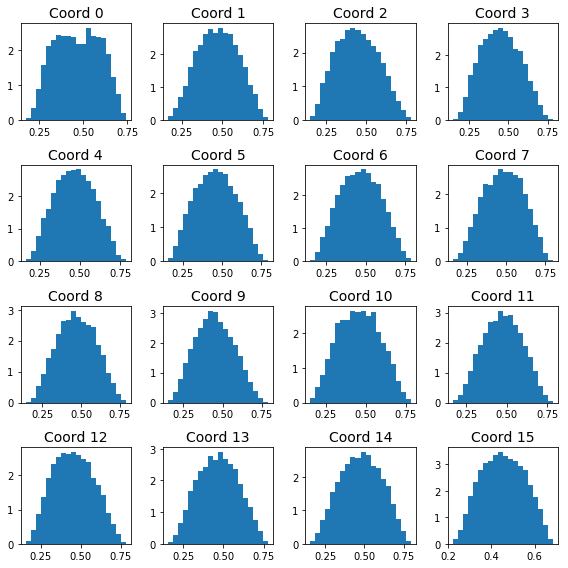

In [97]:
n_examples = 10000
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
m_enc = alice.predict([m_batch, k_batch])

if showAll:
    n_cols = 4
    n_rows = m_enc.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(8, int(8.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(m_enc[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=12)
            plt.hist(m_enc[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
#plt.savefig("images/" + model_name + "-encall.png", transparent=True) #dpi=100
plt.show()

In [99]:
# Let's examine various correlations, if any
data_arr = np.c_[m_batch, k_batch, m_enc]

columns = [
    'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 
    'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 
    'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 
]

data = pd.DataFrame(data=data_arr, index=range(10000), columns=columns)
data.head()

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.641658,0.438655,0.454572,0.338944,0.359068,0.304524,0.346738,0.527715,0.365368,0.418363
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.635538,0.387321,0.581852,0.331144,0.429219,0.715860,0.297300,0.336093,0.437598,0.487241
2,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.610588,0.532025,0.541423,0.537167,0.350070,0.295901,0.333222,0.676837,0.553554,0.330601
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.434380,0.405799,0.390896,0.548822,0.601871,0.525954,0.664372,0.356858,0.508475,0.435876
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.437969,0.562219,0.542789,0.382660,0.353728,0.321736,0.488413,0.661269,0.576552,0.475243


In [106]:
datac = data[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']]
datac.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,0.632454,0.476783,0.507089,0.624238,0.586194,0.734539,0.641658,0.438655,0.454572,0.338944,0.359068,0.304524,0.346738,0.527715,0.365368,0.418363
1,0.491801,0.481413,0.407196,0.195773,0.464092,0.598038,0.635538,0.387321,0.581852,0.331144,0.429219,0.715860,0.297300,0.336093,0.437598,0.487241
2,0.275932,0.498468,0.424380,0.214435,0.543027,0.503169,0.610588,0.532025,0.541423,0.537167,0.350070,0.295901,0.333222,0.676837,0.553554,0.330601
3,0.310727,0.573348,0.312155,0.470821,0.351790,0.597028,0.434380,0.405799,0.390896,0.548822,0.601871,0.525954,0.664372,0.356858,0.508475,0.435876
4,0.331818,0.501676,0.699930,0.401564,0.570070,0.352487,0.437969,0.562219,0.542789,0.382660,0.353728,0.321736,0.488413,0.661269,0.576552,0.475243


In [107]:
corr = data.corr()
corrc = datac.corr()

In [118]:
corrc['c2'].sort_values(ascending=False)

c2     1.000000
c1     0.187464
c11    0.134926
c3     0.112842
c0     0.107025
c14    0.077918
c15    0.037939
c5     0.033308
c4     0.026219
c9     0.024584
c6     0.020200
c12    0.020067
c13   -0.003340
c8    -0.015999
c7    -0.026283
c10   -0.040257
Name: c2, dtype: float64

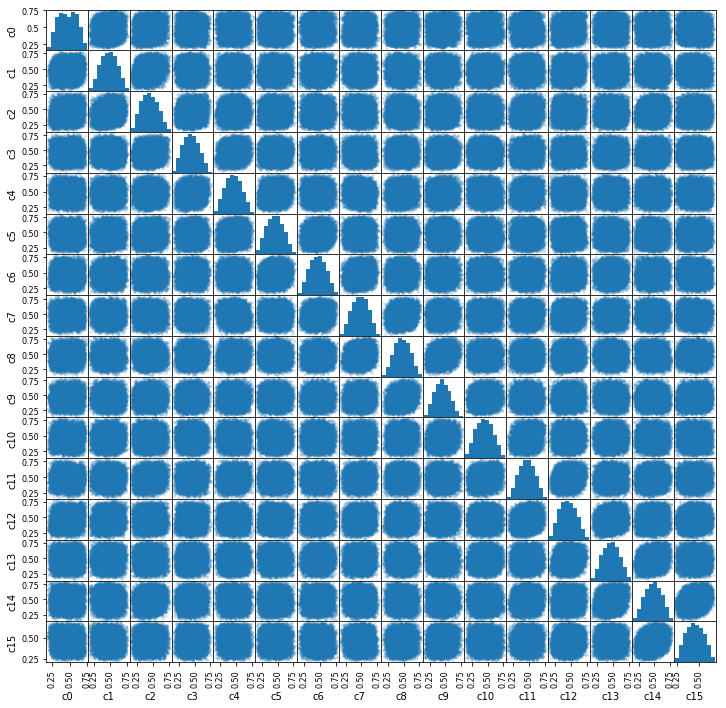

In [116]:
pd.plotting.scatter_matrix(datac, alpha=0.2, figsize=(12,12))
plt.show()

## Model `crypto2`

Add dense, and allow tanh for codings.

In [56]:
K.floatx()

'float32'

In [57]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [58]:
K.clear_session()
kersize = 4

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [59]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [60]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [61]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


### Train / save / restore

In [62]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [63]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
Epoch   0:  99% | abe: 2.678 | eve: 2.393 | bob: 2.483
Epoch   1:  99% | abe: 1.453 | eve: 1.710 | bob: 1.115
Epoch   2:  99% | abe: 0.793 | eve: 2.265 | bob: 0.597
Epoch   3:  99% | abe: 0.553 | eve: 2.449 | bob: 0.397
Epoch   4:  99% | abe: 0.424 | eve: 2.631 | bob: 0.305
Epoch   5:  99% | abe: 0.359 | eve: 2.930 | bob: 0.286
Epoch   6:  99% | abe: 0.345 | eve: 2.968 | bob: 0.275
Epoch   7:  99% | abe: 0.333 | eve: 3.034 | bob: 0.271
Epoch   8:  99% | abe: 0.338 | eve: 2.940 | bob: 0.265
Epoch   9:  99% | abe: 0.332 | eve: 2.981 | bob: 0.265
Epoch  10:  99% | abe: 0.317 | eve: 3.071 | bob: 0.260
Epoch  11:  99% | abe: 0.315 | eve: 3.091 | bob: 0.262
Epoch  12:  99% | abe: 0.312 | eve: 3.107 | bob: 0.260
Epoch  13:  99% | abe: 0.316 | eve: 3.098 | bob: 0.263
Epoch  14:  99% | abe: 0.303 | eve: 3.171 | bob: 0.258
Epoch  15:  99% | abe: 0.309 | eve: 3.112 | bob: 0.259
Epoch  16:  99% | abe: 0.307 | eve: 3.107 | bob: 0.256
Epoch  17:  9

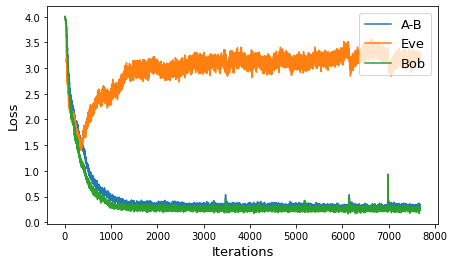

In [64]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

#plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [66]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

In [67]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [68]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  74.11 %
Eve % correct:  1.51 %


# Model 3

# Asymmetric (public-key) encryption

## Model crypto3 (Google)

In [2]:
# Coming soon

# AI-based encryption (POC)

Let's take model `crypto2`, for which Bob was incredibly accurate while Eve failed to decrypt the messages.

We construct a full encryption, with 32-bit float ciphertexts (vector of dim 8), so each character will encode to 32 * 8 = 256 bits

**Encryption Algorithm:**
* Convert character string to binary
* Pad the binary char encoding string wtih 3 random bits to get a block of 8 bits per character
* Pass 8-bit blocks of the string through the encryption network Bob
* The output is 8-dim vectors of type `float32`, for a total of $8 \cdot 32 = 256$ bits per character
* Convert the output to a binary string by concatenating the binary representation of each component the 8-dim float vector. **This is the encoding**

One could convert this to a character string to see what the messasge might look like. Each character will be a block of 5 (remove 3 bits for padding).

The decryption algorithm is the reverse of the above.

In [126]:
alice = load_model('models/crypto/crypto2-alice.h5')
bob = load_model('models/crypto/crypto2-bob.h5')
eve = load_model('models/crypto/crypto2-eve.h5')

## Char map and str functions

In [127]:
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding

chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

In [138]:
print(encstr('adi', 3))
print(decstr('00010011010001001001001001010011', 4, block_padding=3))

('000000001100001100001000', 3)
test


In [129]:
# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

In [161]:
key = np.array([[0,0,0,0,0,0,0,0]])
m = 'adi'

m_bin, _ = encstr(m, block_padding=3)
m_bin_len = len(m_bin)
print(m_bin, m_bin_len)

ciphertext = ""
for i in range(m_bin_len // m_bits):
    # read blocks of size m_bits
    binblockstr = m_bin[m_bits*i : m_bits*i + m_bits]
    binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)
    
    floatVector = alice.predict([binblock, key])
    #print(np.round(floatVector,3))
    
    # convert each coordinate of the cipher (float) vector to binary
    # and construct the binary ciphertext
    for j in range(c_bits):
        ciphertext = ciphertext + float_to_binary(floatVector[0][j])
        #print(float_to_binary(floatVector[0][j]))

#print(ciphertext, len(ciphertext)) # ciphertext in binary
print(decstr(ciphertext, n=(len(ciphertext)//8), block_padding=3)) #ciphertext as characters

ciphertext_len = len(ciphertext)
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    # read the ciphertext in chunks of 32*c_bits bits, i.e one encoding at a time
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    #print(floatVectorbin)
    # convert the binary chunk to an 8-dim float vector (input for AI Bob)
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        #print(floatValuebin)
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    #print(np.round(floatVector,3))
    
    charbinvector = list( (bob.predict([floatVector, key]) > 0.5)[0].astype(int) )
    for j in range(len(charbinvector)):
        plaintextbin = plaintextbin + str(charbinvector[j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

001000001100001101001000 24
?pfx?bhj?t,z!!ma!nhr:exs!qlt,apl:id?.j..?eu??lzr?yjg:lfo!bun?j?l?qfl?uuo?usb!ztg?uqh:mte?vuq? j 
001000001100001101001000
adi


In [151]:
# How would Eve peform on the above ciphertext?

plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    charbinvector = (eve.predict(floatVector) > 0.5).astype(int)
    for j in range(charbinvector.shape[1]):
        plaintextbin = plaintextbin + str(charbinvector[0][j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

111111001111110111111101
!??


# End